# 14강: CNN 성능 최적화와 하이퍼파라미터 튜닝

## 🎯 학습 목표
- CNN 성능을 향상시키는 다양한 최적화 기법 이해
- 하이퍼파라미터 튜닝의 체계적 접근법 학습
- 과적합 방지 기법의 원리와 실제 적용
- 학습률 스케줄링과 배치 정규화 활용

---

## 📚 강의 개요 (60분)
1. CNN 최적화 기법 (20분)
2. 하이퍼파라미터 튜닝 (20분)
3. 과적합 방지 및 정규화 (20분)

> **이전 강의 복습**: 13강에서 이미지 전처리와 데이터 증강으로 기본 성능을 확보했습니다. 이제 더 깊이 들어가 보겠습니다!


## 1. 환경 설정 및 라이브러리 임포트


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR, ReduceLROnPlateau
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import random
from itertools import product

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# 시드 설정으로 재현 가능한 결과 보장
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# GPU 사용 가능 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'🚀 사용 디바이스: {device}')
if torch.cuda.is_available():
    print(f'🔥 GPU 이름: {torch.cuda.get_device_name(0)}')
    print(f'💾 GPU 메모리: {torch.cuda.get_device_properties(0).total_memory // 1024**3} GB')

print("✅ 환경 설정 완료!")


🚀 사용 디바이스: cuda
🔥 GPU 이름: NVIDIA GeForce RTX 4060 Ti
💾 GPU 메모리: 15 GB
✅ 환경 설정 완료!


## 2. CNN 성능 최적화 기법

### 📚 성능 최적화가 중요한 이유

**🎯 목표**: 같은 데이터와 모델로도 더 좋은 성능을 얻어내기!

### 🛠️ 주요 최적화 기법들

| 기법 | 설명 | 효과 |
|------|------|------|
| **배치 정규화** | 각 층의 입력을 정규화 | 학습 안정화, 속도 향상 |
| **학습률 스케줄링** | 학습 과정에서 학습률 조정 | 더 좋은 최적점 찾기 |
| **옵티마이저 선택** | Adam, SGD, RMSprop 등 | 수렴 속도와 안정성 개선 |
| **드롭아웃** | 무작위로 뉴런 비활성화 | 과적합 방지 |
| **가중치 초기화** | 적절한 초기 가중치 설정 | 학습 시작점 최적화 |

### 🔬 배치 정규화(Batch Normalization)의 원리

**💡 핵심 아이디어**: 각 층의 입력을 평균 0, 분산 1로 정규화

```
BN(x) = γ × (x - μ) / σ + β
```

- μ: 배치 평균
- σ: 배치 표준편차  
- γ, β: 학습 가능한 파라미터

**🎯 효과:**
- 기울기 소실/폭발 문제 완화
- 높은 학습률 사용 가능
- 초기화에 덜 민감
- 일종의 정규화 효과


### 2.1 데이터 준비 및 최적화된 모델 구성


In [3]:
# 📊 CIFAR-10 데이터 준비 (최적화된 전처리)
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 데이터셋 로드
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform_test)

# 훈련/검증 데이터 분할 (90%/10%)
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# 데이터 로더 생성
batch_size = 128
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"📊 데이터 구성:")
print(f"   훈련: {len(train_subset):,}개")
print(f"   검증: {len(val_subset):,}개") 
print(f"   테스트: {len(test_dataset):,}개")

# CIFAR-10 클래스 이름
cifar10_classes = ['비행기', '자동차', '새', '고양이', '사슴', 
                   '개', '개구리', '말', '배', '트럭']

print(f"🏷️  클래스: {cifar10_classes}")
print("✅ 데이터 준비 완료!")


📊 데이터 구성:
   훈련: 45,000개
   검증: 5,000개
   테스트: 10,000개
🏷️  클래스: ['비행기', '자동차', '새', '고양이', '사슴', '개', '개구리', '말', '배', '트럭']
✅ 데이터 준비 완료!


### 2.2 기본 vs 최적화 모델 비교


In [4]:
# 🔵 기본 CNN 모델 (최적화 기법 없음)
def create_basic_cnn():
    """기본 CNN 모델 - 최적화 기법 적용 전"""
    model = nn.Sequential(
        # 첫 번째 블록
        nn.Conv2d(3, 32, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        
        # 두 번째 블록
        nn.Conv2d(64, 128, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        
        # 분류기
        nn.Flatten(),
        nn.Linear(128 * 8 * 8, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    )
    return model

# 🔥 최적화된 CNN 모델 (모든 최적화 기법 적용)
def create_optimized_cnn():
    """최적화된 CNN 모델 - 배치정규화, 드롭아웃 등 적용"""
    model = nn.Sequential(
        # 첫 번째 블록 (최적화 적용)
        nn.Conv2d(3, 32, 3, padding=1),
        nn.BatchNorm2d(32),              # 🔥 배치 정규화
        nn.ReLU(),
        nn.Conv2d(32, 64, 3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Dropout2d(0.25),              # 🔥 2D 드롭아웃
        
        # 두 번째 블록 (최적화 적용)
        nn.Conv2d(64, 128, 3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(128, 128, 3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Dropout2d(0.25),
        
        # 세 번째 블록 추가
        nn.Conv2d(128, 256, 3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Dropout2d(0.25),
        
        # 최적화된 분류기
        nn.Flatten(),
        nn.Linear(256 * 4 * 4, 512),
        nn.BatchNorm1d(512),             # 🔥 1D 배치 정규화
        nn.ReLU(),
        nn.Dropout(0.5),                 # 🔥 드롭아웃
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, 10)
    )
    return model

# 모델 생성
basic_model = create_basic_cnn().to(device)
optimized_model = create_optimized_cnn().to(device)

print("🏗️ 모델 생성 완료!")
print(f"📊 기본 모델 파라미터: {sum(p.numel() for p in basic_model.parameters()):,}개")
print(f"🔥 최적화 모델 파라미터: {sum(p.numel() for p in optimized_model.parameters()):,}개")

print("\n🔍 주요 차이점:")
print("   🔵 기본 모델: 기본 Conv2d + ReLU + MaxPool")
print("   🔥 최적화 모델: BatchNorm + Dropout + 더 깊은 구조")

print("\n✅ 모델 준비 완료!")


🏗️ 모델 생성 완료!
📊 기본 모델 파라미터: 2,340,810개
🔥 최적화 모델 파라미터: 2,770,314개

🔍 주요 차이점:
   🔵 기본 모델: 기본 Conv2d + ReLU + MaxPool
   🔥 최적화 모델: BatchNorm + Dropout + 더 깊은 구조

✅ 모델 준비 완료!


## 3. 하이퍼파라미터 튜닝

### 🎛️ 하이퍼파라미터란?

**하이퍼파라미터**는 모델 학습 전에 사용자가 설정해야 하는 값들입니다.

### 🔧 주요 하이퍼파라미터들

| 종류 | 하이퍼파라미터 | 일반적 범위 | 영향 |
|------|----------------|-------------|------|
| **옵티마이저** | 학습률 (lr) | 0.0001 ~ 0.1 | 수렴 속도와 안정성 |
| **모델 구조** | 배치 크기 | 16 ~ 512 | 메모리 사용량, 수렴성 |
| **정규화** | 드롭아웃 비율 | 0.1 ~ 0.7 | 과적합 방지 |
| **스케줄링** | 학습률 감소율 | 0.1 ~ 0.9 | 성능 향상 |

### 🎯 튜닝 전략

1. **그리드 서치**: 모든 조합 체계적 탐색
2. **랜덤 서치**: 무작위 샘플링
3. **베이지안 최적화**: 이전 결과 활용한 지능적 탐색


### 3.1 간단한 하이퍼파라미터 탐색 실험


In [6]:
# 🎛️ 간단한 학습 함수 (하이퍼파라미터 실험용)
def quick_train(model, train_loader, val_loader, lr=0.001, epochs=3):
    """빠른 학습 함수 - 하이퍼파라미터 탐색용"""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            if batch_idx > 50:  # 빠른 실험을 위해 50배치만
                break
            
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
    
    # 검증 정확도 측정
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    val_accuracy = 100. * correct / total
    return val_accuracy

# 🔍 하이퍼파라미터 탐색 공간 정의
hyperparams = {
    'learning_rate': [0.001, 0.003, 0.01],
    'optimizer': ['Adam', 'SGD'],
    'batch_size': [64, 128]  # 간단히 2개만 테스트
}

print("🎛️ 하이퍼파라미터 탐색 시작!")
print(f"📊 탐색 공간: {hyperparams}")

results = []

# 그리드 서치 실행
for lr in hyperparams['learning_rate']:
    for opt_name in hyperparams['optimizer']:
        for bs in hyperparams['batch_size']:
            print(f"\\n🧪 테스트 중: lr={lr}, optimizer={opt_name}, batch_size={bs}")
            
            # 새로운 모델 생성 (매번 초기화)
            test_model = create_optimized_cnn().to(device)
            
            # 배치 크기에 맞는 새로운 데이터 로더
            temp_train_loader = DataLoader(train_subset, batch_size=bs, shuffle=True)
            temp_val_loader = DataLoader(val_subset, batch_size=bs, shuffle=False)
            
            # 옵티마이저 설정
            if opt_name == 'Adam':
                optimizer = optim.Adam(test_model.parameters(), lr=lr)
            else:
                optimizer = optim.SGD(test_model.parameters(), lr=lr, momentum=0.9)
            
            # 빠른 학습 및 평가
            try:
                val_acc = quick_train(test_model, temp_train_loader, temp_val_loader, lr=lr)
                
                results.append({
                    'learning_rate': lr,
                    'optimizer': opt_name,
                    'batch_size': bs,
                    'val_accuracy': val_acc
                })
                
                print(f"   ✅ 검증 정확도: {val_acc:.2f}%")
                
            except Exception as e:
                print(f"   ❌ 실패: {e}")
                continue

# 결과 정리
results_df = pd.DataFrame(results)
if len(results_df) > 0:
    best_config = results_df.loc[results_df['val_accuracy'].idxmax()]
    
    print("\\n" + "="*50)
    print("🏆 하이퍼파라미터 탐색 결과")
    print("="*50)
    print(results_df.to_string(index=False))
    print(f"\\n🥇 최고 성능 설정:")
    print(f"   학습률: {best_config['learning_rate']}")
    print(f"   옵티마이저: {best_config['optimizer']}")
    print(f"   배치 크기: {best_config['batch_size']}")
    print(f"   검증 정확도: {best_config['val_accuracy']:.2f}%")
else:
    print("❌ 유효한 결과가 없습니다.")


🎛️ 하이퍼파라미터 탐색 시작!
📊 탐색 공간: {'learning_rate': [0.001, 0.003, 0.01], 'optimizer': ['Adam', 'SGD'], 'batch_size': [64, 128]}
\n🧪 테스트 중: lr=0.001, optimizer=Adam, batch_size=64
   ✅ 검증 정확도: 35.86%
\n🧪 테스트 중: lr=0.001, optimizer=Adam, batch_size=128
   ✅ 검증 정확도: 43.74%
\n🧪 테스트 중: lr=0.001, optimizer=SGD, batch_size=64
   ✅ 검증 정확도: 38.40%
\n🧪 테스트 중: lr=0.001, optimizer=SGD, batch_size=128
   ✅ 검증 정확도: 43.30%
\n🧪 테스트 중: lr=0.003, optimizer=Adam, batch_size=64
   ✅ 검증 정확도: 34.20%
\n🧪 테스트 중: lr=0.003, optimizer=Adam, batch_size=128
   ✅ 검증 정확도: 43.98%
\n🧪 테스트 중: lr=0.003, optimizer=SGD, batch_size=64
   ✅ 검증 정확도: 34.28%
\n🧪 테스트 중: lr=0.003, optimizer=SGD, batch_size=128
   ✅ 검증 정확도: 41.16%
\n🧪 테스트 중: lr=0.01, optimizer=Adam, batch_size=64
   ✅ 검증 정확도: 31.20%
\n🧪 테스트 중: lr=0.01, optimizer=Adam, batch_size=128
   ✅ 검증 정확도: 38.26%
\n🧪 테스트 중: lr=0.01, optimizer=SGD, batch_size=64
   ✅ 검증 정확도: 34.62%
\n🧪 테스트 중: lr=0.01, optimizer=SGD, batch_size=128
   ✅ 검증 정확도: 36.84%
\n============================

## 4. 학습률 스케줄링과 고급 최적화

### 📈 학습률 스케줄링이란?

**학습률 스케줄링**은 훈련 과정에서 학습률을 동적으로 조정하는 기법입니다.

### 🎯 왜 필요할까요?

1. **초기**: 큰 학습률로 빠른 수렴
2. **중기**: 적당한 학습률로 안정적 학습  
3. **후기**: 작은 학습률로 세밀한 조정

### 🔧 주요 스케줄링 방법

| 방법 | 설명 | 장점 | 단점 |
|------|------|------|------|
| **StepLR** | 일정 에포크마다 감소 | 간단, 안정적 | 경직적 |
| **CosineAnnealingLR** | 코사인 함수로 감소 | 부드러운 변화 | 하이퍼파라미터 민감 |
| **ReduceLROnPlateau** | 성능 정체시 감소 | 적응적 | 지연 반응 |


### 4.1 학습률 스케줄링 비교 실험


In [7]:
# 📈 학습률 스케줄링 실험
def train_with_scheduler(model, train_loader, val_loader, scheduler_type='none', epochs=5):
    """스케줄러별 학습 함수"""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)  # 높은 초기 학습률
    
    # 스케줄러 설정
    if scheduler_type == 'step':
        scheduler = StepLR(optimizer, step_size=2, gamma=0.5)  # 2에포크마다 절반으로
    elif scheduler_type == 'cosine':
        scheduler = CosineAnnealingLR(optimizer, T_max=epochs)
    elif scheduler_type == 'plateau':
        scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=1, factor=0.5)
    else:
        scheduler = None
    
    train_losses = []
    val_accuracies = []
    learning_rates = []
    
    print(f"🚀 {scheduler_type} 스케줄러로 학습 시작!")
    
    for epoch in range(epochs):
        # 훈련
        model.train()
        running_loss = 0.0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            if batch_idx > 100:  # 빠른 실험을 위해
                break
                
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        epoch_loss = running_loss / min(len(train_loader), 100)
        train_losses.append(epoch_loss)
        
        # 검증
        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        
        val_acc = 100. * correct / total
        val_accuracies.append(val_acc)
        
        # 현재 학습률 기록
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)
        
        print(f"   에포크 {epoch+1}: 손실={epoch_loss:.4f}, 정확도={val_acc:.2f}%, 학습률={current_lr:.6f}")
        
        # 스케줄러 업데이트
        if scheduler is not None:
            if scheduler_type == 'plateau':
                scheduler.step(val_acc)  # 검증 정확도 기준
            else:
                scheduler.step()
    
    return train_losses, val_accuracies, learning_rates

# 🧪 다양한 스케줄러 실험
schedulers_to_test = ['none', 'step', 'cosine', 'plateau']
scheduler_results = {}

for scheduler_name in schedulers_to_test:
    print(f"\\n{'='*40}")
    print(f"🔬 {scheduler_name.upper()} 스케줄러 테스트")
    print('='*40)
    
    # 새로운 모델로 실험
    test_model = create_optimized_cnn().to(device)
    
    try:
        losses, accuracies, lrs = train_with_scheduler(
            test_model, train_loader, val_loader, 
            scheduler_type=scheduler_name, epochs=5
        )
        
        scheduler_results[scheduler_name] = {
            'losses': losses,
            'accuracies': accuracies,
            'learning_rates': lrs,
            'final_accuracy': accuracies[-1]
        }
        
        print(f"✅ 최종 정확도: {accuracies[-1]:.2f}%")
        
    except Exception as e:
        print(f"❌ 실험 실패: {e}")
        continue

print("\\n🏁 모든 스케줄러 실험 완료!")


\n========================================
🔬 NONE 스케줄러 테스트
🚀 none 스케줄러로 학습 시작!
   에포크 1: 손실=2.0268, 정확도=35.52%, 학습률=0.010000
   에포크 2: 손실=1.7846, 정확도=39.92%, 학습률=0.010000
   에포크 3: 손실=1.6477, 정확도=43.46%, 학습률=0.010000
   에포크 4: 손실=1.5542, 정확도=49.04%, 학습률=0.010000
   에포크 5: 손실=1.4851, 정확도=52.66%, 학습률=0.010000
✅ 최종 정확도: 52.66%
\n========================================
🔬 STEP 스케줄러 테스트
🚀 step 스케줄러로 학습 시작!
   에포크 1: 손실=2.0668, 정확도=31.76%, 학습률=0.010000
   에포크 2: 손실=1.7972, 정확도=40.18%, 학습률=0.010000
   에포크 3: 손실=1.6473, 정확도=44.14%, 학습률=0.005000
   에포크 4: 손실=1.5924, 정확도=44.76%, 학습률=0.005000
   에포크 5: 손실=1.4949, 정확도=52.08%, 학습률=0.002500
✅ 최종 정확도: 52.08%
\n========================================
🔬 COSINE 스케줄러 테스트
🚀 cosine 스케줄러로 학습 시작!
   에포크 1: 손실=2.0610, 정확도=34.08%, 학습률=0.010000
   에포크 2: 손실=1.7981, 정확도=40.40%, 학습률=0.009045
   에포크 3: 손실=1.6666, 정확도=43.50%, 학습률=0.006545
   에포크 4: 손실=1.5660, 정확도=48.50%, 학습률=0.003455
   에포크 5: 손실=1.5008, 정확도=50.82%, 학습률=0.000955
✅ 최종 정확도: 50.82%
\n================

### 4.2 스케줄러 성능 비교 시각화


/tmp/ipykernel_485795/3334939938.py:57: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_485795/3334939938.py:57: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_485795/3334939938.py:57: UserWarning: Glyph 53356 (\N{HANGUL SYLLABLE KEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_485795/3334939938.py:57: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_485795/3334939938.py:57: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_485795/3334939938.py:57: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_485795/3334939938.py:57: UserWarning: Glyph 44160 (\N{HANGUL SYLLABLE GEOM}) missing from font(s) DejaVu Sans.

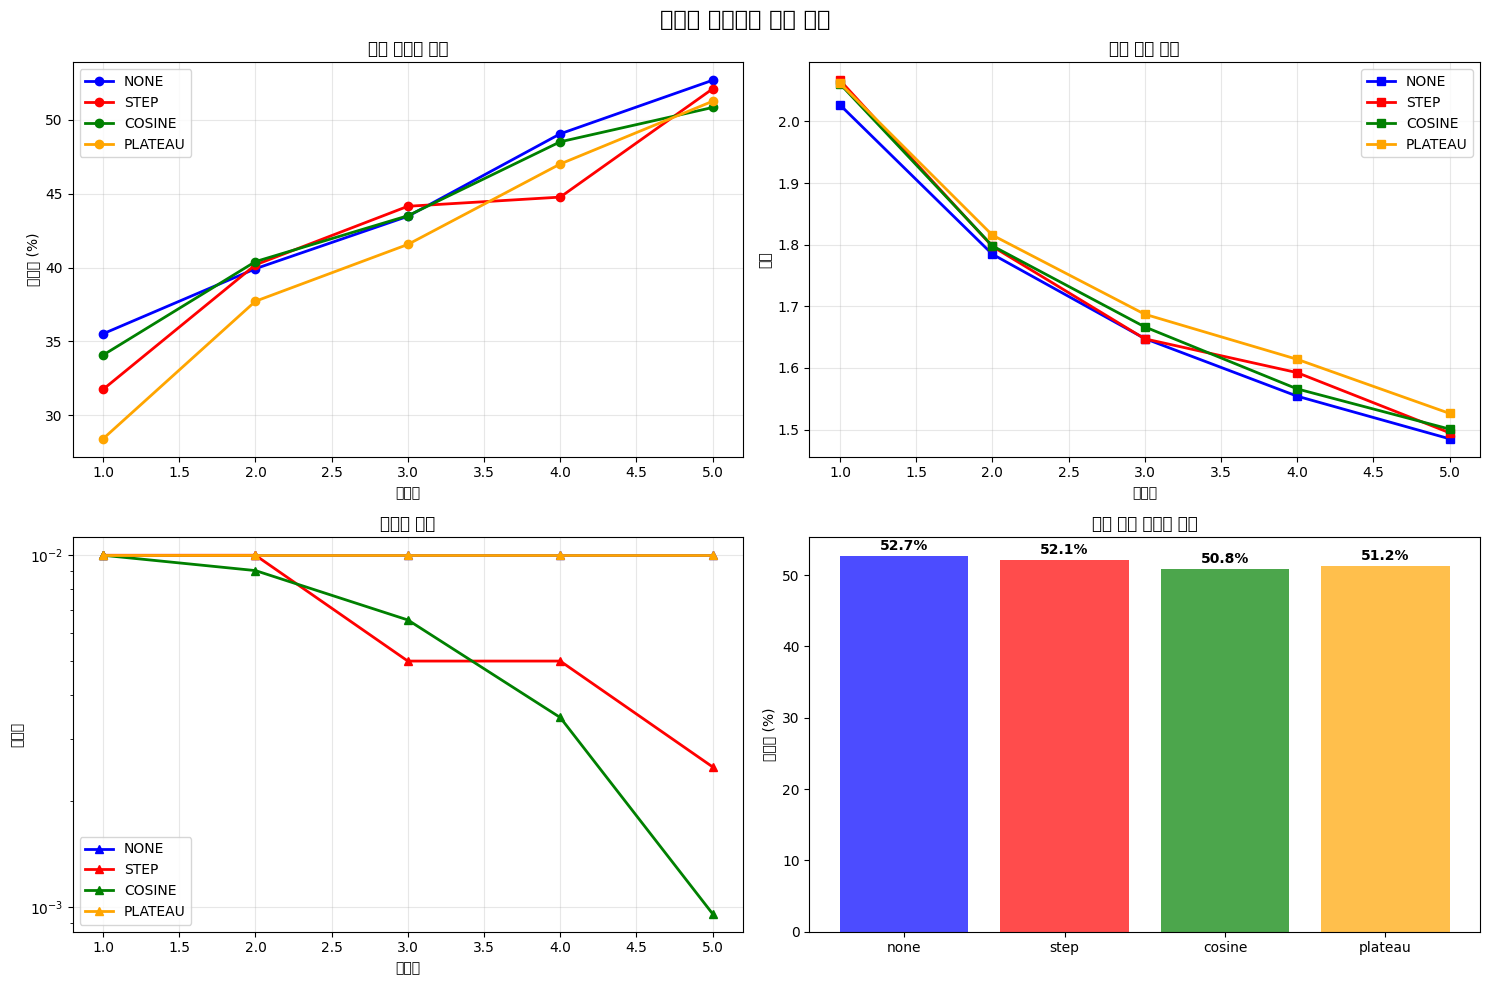

\n==================================================
🏆 스케줄러 실험 결과 요약
NONE      : 최종 정확도 52.66%
STEP      : 최종 정확도 52.08%
COSINE    : 최종 정확도 50.82%
PLATEAU   : 최종 정확도 51.24%
\n🥇 최고 성능: NONE (52.66%)
\n💡 스케줄러별 특징:
   📘 NONE: 고정 학습률, 안정적이지만 성능 제한
   🔴 STEP: 단계적 감소, 간단하고 효과적
   🟢 COSINE: 부드러운 감소, 세밀한 조정 가능
   🟠 PLATEAU: 적응적 감소, 성능 정체시 자동 조정


In [8]:
# 📊 스케줄러 결과 시각화
if scheduler_results:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('학습률 스케줄러 성능 비교', fontsize=16, fontweight='bold')
    
    epochs_range = range(1, 6)
    colors = ['blue', 'red', 'green', 'orange']
    
    # 1. 검증 정확도 비교
    for i, (name, results) in enumerate(scheduler_results.items()):
        ax1.plot(epochs_range, results['accuracies'], 
                color=colors[i], marker='o', label=name.upper(), linewidth=2)
    
    ax1.set_title('검증 정확도 변화')
    ax1.set_xlabel('에포크')
    ax1.set_ylabel('정확도 (%)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. 훈련 손실 비교
    for i, (name, results) in enumerate(scheduler_results.items()):
        ax2.plot(epochs_range, results['losses'], 
                color=colors[i], marker='s', label=name.upper(), linewidth=2)
    
    ax2.set_title('훈련 손실 변화')
    ax2.set_xlabel('에포크')
    ax2.set_ylabel('손실')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. 학습률 변화
    for i, (name, results) in enumerate(scheduler_results.items()):
        ax3.plot(epochs_range, results['learning_rates'], 
                color=colors[i], marker='^', label=name.upper(), linewidth=2)
    
    ax3.set_title('학습률 변화')
    ax3.set_xlabel('에포크')
    ax3.set_ylabel('학습률')
    ax3.set_yscale('log')  # 로그 스케일로 표시
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. 최종 성능 막대 그래프
    scheduler_names = list(scheduler_results.keys())
    final_accs = [results['final_accuracy'] for results in scheduler_results.values()]
    
    bars = ax4.bar(scheduler_names, final_accs, color=colors[:len(scheduler_names)], alpha=0.7)
    ax4.set_title('최종 검증 정확도 비교')
    ax4.set_ylabel('정확도 (%)')
    
    # 막대 위에 정확도 표시
    for bar, acc in zip(bars, final_accs):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # 📈 결과 요약
    best_scheduler = max(scheduler_results.items(), key=lambda x: x[1]['final_accuracy'])
    
    print("\\n" + "="*50)
    print("🏆 스케줄러 실험 결과 요약")
    print("="*50)
    
    for name, results in scheduler_results.items():
        print(f"{name.upper():10}: 최종 정확도 {results['final_accuracy']:.2f}%")
    
    print(f"\\n🥇 최고 성능: {best_scheduler[0].upper()} ({best_scheduler[1]['final_accuracy']:.2f}%)")
    
    print("\\n💡 스케줄러별 특징:")
    print("   📘 NONE: 고정 학습률, 안정적이지만 성능 제한")
    print("   🔴 STEP: 단계적 감소, 간단하고 효과적") 
    print("   🟢 COSINE: 부드러운 감소, 세밀한 조정 가능")
    print("   🟠 PLATEAU: 적응적 감소, 성능 정체시 자동 조정")

else:
    print("❌ 스케줄러 실험 결과가 없습니다.")


## 5. 강의 정리 및 실무 가이드

### 🎯 오늘 배운 핵심 내용

1. **🛠️ CNN 최적화 기법**
   - 배치 정규화로 학습 안정화
   - 드롭아웃으로 과적합 방지
   - 적절한 모델 구조 설계

2. **🎛️ 하이퍼파라미터 튜닝**
   - 체계적인 탐색 전략 (그리드 서치)
   - 주요 하이퍼파라미터 식별
   - 검증 데이터로 성능 평가

3. **📈 학습률 스케줄링**
   - 다양한 스케줄러 비교
   - 훈련 과정에서 동적 조정
   - 성능 향상 확인

### 💡 실무 적용 가이드

#### 🚀 성능 향상 체크리스트

**1단계: 기본 최적화**
- [ ] 배치 정규화 추가
- [ ] 적절한 드롭아웃 적용
- [ ] 데이터 증강 활용

**2단계: 하이퍼파라미터 조정**
- [ ] 학습률 탐색 (0.0001 ~ 0.1)
- [ ] 배치 크기 최적화
- [ ] 옵티마이저 선택 (Adam vs SGD)

**3단계: 고급 기법**
- [ ] 학습률 스케줄링 적용
- [ ] 조기 종료 (Early Stopping)
- [ ] 모델 앙상블

#### ⚠️ 주의사항

1. **과적합 신호**
   - 훈련 정확도 >> 검증 정확도
   - 검증 손실이 증가하기 시작

2. **하이퍼파라미터 과최적화**
   - 검증 데이터에만 좋은 성능
   - 테스트 데이터에서 성능 저하

3. **계산 비용 고려**
   - GPU 메모리 한계
   - 학습 시간 vs 성능 트레이드오프

### 📝 다음 강의 예고
15강에서는 전이학습(Transfer Learning)과 사전훈련된 모델 활용에 대해 알아보겠습니다!
